[CNN CUSTOM DATASET + MODEL ]

- 사용자 정의 이미지 데이터셋 생성 => ImageFolder
- 사용자 정의 CNN 기반 모델
- 데이터 : 강아지, 고양이 사진 

In [1]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import ImageFolder      # 이미지용 데이터셋 생성
from torch.utils.data import DataLoader           # 데이터로더
from torchvision.transforms import transforms     # 이미지 전처리 및 증강 모듈 

import matplotlib.pyplot as plt

In [2]:
# 데이터 준비 
IMG_ROOT = '../D0402/cat_dog/'

In [3]:
# 이미지 전처리 및 변형
# resize : 이미지 크기 통일                -> transforms.Resize((shape))
# tensor화 : Pytorch 모델 입력 타입 변환   -> transforms.ToTensor() : 텐서화 + 정규화(0.~1.)
preprocessing = transforms.Compose([transforms.Resize((100,100)),
                                    transforms.ToTensor()])

In [4]:
# 이미지 데이터 로딩
imgDS = ImageFolder(root=IMG_ROOT, transform=preprocessing)

## - 클래스 변환 데이터 
IDX_TO_CLASS = {v:k for k, v in imgDS.class_to_idx.items()}
print(f'IDX_TO_CLASS => {IDX_TO_CLASS}')

IDX_TO_CLASS => {0: 'cat', 1: 'dog'}


In [5]:
# 데이터셋 체크
# - 타입
print(f'타입 : {type(imgDS)}')

# - 속성 : 클래스 정보
print(f'클래스 : {imgDS.classes}')
print(f'클래스 인덱스 : {imgDS.class_to_idx}')

# - 속성 : 데이터와 타겟
print(f'타겟 : {imgDS.targets}')
print(f'경로 : {imgDS.imgs}')

타입 : <class 'torchvision.datasets.folder.ImageFolder'>
클래스 : ['cat', 'dog']
클래스 인덱스 : {'cat': 0, 'dog': 1}
타겟 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<class 'torch.Tensor'> tensor(0.) tensor(0.7216)


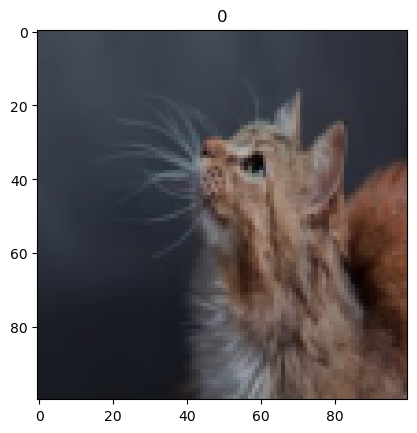

In [6]:
# 내부적으로 __getitem__() 호출되면서 이미지 데이터와 타겟 반환
rawIMG, target = imgDS[70]

# max, min 확인
print(type(rawIMG), rawIMG.min(), rawIMG.max())

# 텐서 그림으로 나타내기 위해 축 변경 (채널, 높이, 너비) -> (높이, 너비, 채널)
plt.imshow(rawIMG.permute(1,2,0))
plt.title(target)
plt.show()

In [7]:
# 비율 확인 
from collections import Counter

class_counts = Counter(imgDS.targets)
class_counts

Counter({1: 1620, 0: 1240})

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.model_selection import train_test_split

## 전체 데이터 수 체크
print('[전체 데이터 수 체크 ]', len(imgDS.imgs), len(imgDS.targets))

## 비율 기준 설정
targets = imgDS.targets

## -------(2) 훈련용:검증용:테스트용 데이터 인덱스 추출
## 1단계: 학습용과 검증용 데이터셋 분리
train_indices, valid_indices = train_test_split(range(len(imgDS.targets)),
                                                test_size=0.2, random_state=42, 
                                                stratify=targets)

## 2단계: 검증용 데이터셋을 테스트용 데이터셋 분리
targets = [ targets[index] for index in valid_indices ]
valid_indices, test_indices= train_test_split( valid_indices,
                                               test_size=0.5, random_state=42, 
                                               stratify=targets)

## -------(3) 훈련용:검증용:테스트용 데이터셋 생성
trainDS = Subset(imgDS, train_indices)
validDS = Subset(imgDS, valid_indices)
testDS = Subset(imgDS, test_indices)

## -------(4) 분리 데이터셋의 클래스 비율 체크
for kind, indices in zip(['Train','Valid','Test'], [trainDS.indices, validDS.indices, testDS.indices]):
    targets = [ imgDS.targets[ idx ] for idx in indices ]
    print(f'\n[{kind} 전체 데이터셋 개수 : {len(targets)}개')
    print(f'        - cat      개수 : {targets.count(0):02}개 {(targets.count(0)/len(targets))*100:.2f}')
    print(f'        - dog      개수 : {targets.count(1):02}개 {(targets.count(1)/len(targets))*100:.2f}')


[전체 데이터 수 체크 ] 2860 2860

[Train 전체 데이터셋 개수 : 2288개
        - cat      개수 : 992개 43.36
        - dog      개수 : 1296개 56.64

[Valid 전체 데이터셋 개수 : 286개
        - cat      개수 : 124개 43.36
        - dog      개수 : 162개 56.64

[Test 전체 데이터셋 개수 : 286개
        - cat      개수 : 124개 43.36
        - dog      개수 : 162개 56.64


In [9]:
## - 훈련용/검증용/테스트용 데이터 로더 생성
train_DL = DataLoader(trainDS, 
                     shuffle=True, 
                     generator=torch.Generator().manual_seed(42))
valid_DL = DataLoader(validDS, shuffle=False)
test_DL  = DataLoader(testDS,  shuffle=False)

torch.Size([1, 3, 100, 100]) tensor([1]) dog


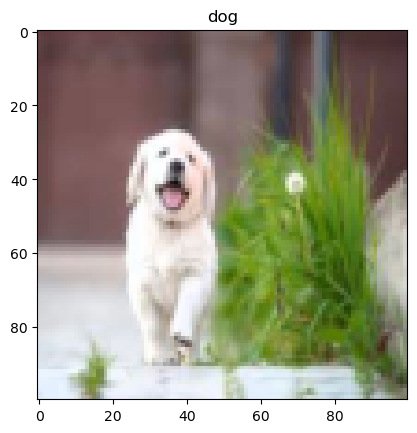

In [12]:
## 체크
img, target = next(iter(train_DL))
print(img.shape, target, IDX_TO_CLASS[target.item()])
plt.imshow(img[0].permute(1,2,0))
plt.title(IDX_TO_CLASS[target.item()])
plt.show()

In [13]:
# 학습 관련 설정
EPOCHS = 50
BATCH_SIZE = 128
ITERATION = int(len(trainDS) / BATCH_SIZE)
LR = 0.01
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE = {DEVICE}')

DEVICE = cpu


In [14]:
# 특징 추출 : 입력 이미지 주요 특징 추출한 특징맵 FeatureMap
#             이미지 채널 / 커널 수      출력 채널 / 커널 수      커널 크기       패딩크기        스트라이드
# 합성곱층  :            3                       1                  3             0               1
#                   커널 크기               스트라이드
# 풀 링 층  :           2                        2              다운샘플링 : 과적합 방지 (Max, Average)
# 플 랫 층  :  ---------------------------------------------------------------------------------------------
    
# 전결합학습 : 추출된 FeatureMap으로 학습 진행 
#             커널 수 * 높이 * 너비       출력 / 퍼셉트론 수 
# 은 닉 층  :       64 * 6 *6                  600
#                      600                     120
#                      120                     1

# class CDCNN(nn.Module):
    
#     def __init__(self):
#         super(CDCNN, self).__init__()
#         # 초기 레이어 : 큰 특성 맵을 유지해 다양한 패턴을 학습 -> Padding 사용(출력 크기 유지, 경계 정보 보존, 모델 설계 유연성)
#         self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
#                                     nn.BatchNorm2d(32),   # 평균과 분산을 이용한 정규화 / out_channels와 동일 
#                                     nn.ReLU(),            
#                                     nn.MaxPool2d(kernel_size=2, stride=2))    # Thanos!!!!! : 보통 절반으로 줄이기 때문에 ks, strides 같은 경우 많음 
#         # 후속 레이어 : 특성 맵의 크기를 축소하며 더 세밀한 정보를 추출 
#         self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#                                     nn.BatchNorm2d(64),
#                                     nn.ReLU(),
#                                     nn.MaxPool2d(2))      # 약식 표기 : stride를 따로 설정하지 않으면 자동으로 kernel_size와 동일한 값으로 설정됨 
#         self.fc1 = nn.Linear(in_features=64*24*24, out_features=600)  # 풀링한 결과가 소수점일 시, 소수점 이하를 버림 
#         self.drop = nn.Dropout2d(0.25)
#         self.fc2 = nn.Linear(in_features=600, out_features=120)
#         self.fc3 = nn.Linear(in_features=120, out_features=1)
        
        
#     def forward(self,x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc1(out)
#         out = self.drop(out)
#         out = self.fc2(out)
#         out = self.fc3(out)
        
#         return out

class CDCNN(nn.Module):
    def __init__(self):
        super(CDCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # 동적 계산을 위해 Adaptive Pooling 활용
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(128, 400)
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 1)
        
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten 처리
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # 출력 활성화 함수 적용
        return x


In [15]:
# 확인 
from torchinfo import summary
m1= CDCNN()
summary(m1, input_size=(1,3,100,100))

Layer (type:depth-idx)                   Output Shape              Param #
CDCNN                                    [1, 1]                    --
├─Sequential: 1-1                        [1, 32, 50, 50]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 100]         896
│    └─BatchNorm2d: 2-2                  [1, 32, 100, 100]         64
│    └─ReLU: 2-3                         [1, 32, 100, 100]         --
│    └─MaxPool2d: 2-4                    [1, 32, 50, 50]           --
├─Sequential: 1-2                        [1, 64, 25, 25]           --
│    └─Conv2d: 2-5                       [1, 64, 50, 50]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 50, 50]           128
│    └─ReLU: 2-7                         [1, 64, 50, 50]           --
│    └─MaxPool2d: 2-8                    [1, 64, 25, 25]           --
├─Sequential: 1-3                        [1, 128, 12, 12]          --
│    └─Conv2d: 2-9                       [1, 128, 25, 25]          73,856
│    

In [ ]:
# 학습 관련 인스턴스들 
import torch.optim as optim
LR = 0.001
model = CDCNN()               # 학습 모델
OPTIMIZER = optim.Adam(model.parameters(),lr=LR)   # 최적화, 즉 경사하강법 알고리즘으로 W,b의 값 갱신 
LOSS_FN = nn.BCELoss()       

In [26]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim      # 최적화 모듈 

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader        ## 학습 데이터셋 관련 모듈
import torchmetrics.functional as mt
from torchmetrics.classification import *  # 분류 

from torchmetrics.classification import BinaryAccuracy


In [27]:
def training():
    # 학습 모드 설정
    model.train()

    E_LOSS, E_ACC = 0, 0
    
    for feature, target in train_DL:  
        # 가중치 기울기 0 초기화
        OPTIMIZER.zero_grad()

        # 학습 진행
        pre_y = model(feature)
        
        # 손실 계산
        loss = LOSS_FN(pre_y, target.reshape(-1, 1).float())
        
        # 정확도 계산
        Accuracy = BinaryAccuracy()
        acc = Accuracy(pre_y, target.reshape(-1, 1).float())
        
        # 역전파 진행
        loss.backward()

        # 가중치/절편 업데이트
        OPTIMIZER.step()

        # 손실 및 정확도 누적
        E_LOSS += loss.item()
        E_ACC += acc.item()

    # 평균 손실 및 정확도 반환
    return E_LOSS / len(train_DL), E_ACC / len(train_DL)


In [28]:
# [6-3] 검증 함수
# - 검증용 데이터셋으로 모델 검증
# - 학습 지속여부 결정 기준이 됨

def evaluate():
    # 에포크 단위로 검증 => 검증 모드
    model.eval()
    
    # W, b가 업데이트 되지 않도록 설정
    with torch.no_grad():
        T_LOSS, T_ACC, CNT = 0, 0, 0
        for feature, target in test_DL:
            # 모델 예측값 계산
            pre_y = model(feature)
            
            # 손실 계산
            loss = LOSS_FN(pre_y, target.reshape(-1, 1).float())
            
            # 정확도 계산
            Accuracy = BinaryAccuracy()
            acc = Accuracy(pre_y, target.reshape(-1, 1).float())
            
            # Loss와 정확도 누적
            T_LOSS += loss.item()
            T_ACC += acc.item()
            CNT += 1
        
        # 평균 Loss와 정확도 반환
        return T_LOSS / CNT, T_ACC / CNT


In [ ]:
MODEL_DIR = './models/'                # 여러 개 
MODEL_FILE = 'catdog_model_vias.pt'    # 1개

In [30]:
from torch.optim.lr_scheduler import ReduceLROnPlateau 

In [65]:
# 에포크 : DS 처음부터 ~ 끝까지 학습  
HIST ={'Train':[[],[]], 'Valid':[[],[]]}   


# 학습 스케쥴러 생성
# patience=5 : 5스택이 쌓이면 학습 중단 
lrScheduler = ReduceLROnPlateau(OPTIMIZER, patience=5, mode='min')

# 조기 종료 카운팅
E_STOP_CNT = 5

Best_ACC = 0

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss, trainAcc = training()
    validLoss, validAcc = evaluate()

    HIST['Train'][0].append(trainLoss)
    HIST['Train'][1].append( trainAcc)

    HIST['Valid'][0].append(validLoss)
    HIST['Valid'][1].append(validAcc)

    print(f'\nEPOCH[{epoch+1}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}  ACC {trainAcc:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}  ACC {validAcc:.5f}')

    lrScheduler.step(validLoss)

    print(f'[{epoch+1}] - num_bad_epochs : {lrScheduler.num_bad_epochs} ')
    
    # 모델 저장 / 모델 층별 가충치 / 바이어스 저장 
    if Best_ACC < validAcc:
        torch.save(model, f'{MODEL_DIR}epoch{epoch+1}_Acc{validAcc:.3f}.pt')
        torch.save(model.state_dict(), MODEL_DIR+MODEL_FILE)
        Best_ACC = validAcc
    
    #  # 모델 층별 가충치 / 바이어스 저장 
    # if Best_ACC < validAcc:
    #     torch.save(model.state_dict(), MODEL_DIR+MODEL_FILE)
    #     Best_ACC = validAcc
    
    if lrScheduler.num_bad_epochs >= lrScheduler.patience:
        print('Early Stopping')
        E_STOP_CNT -= 1
        break
    
    if not E_STOP_CNT:
        print(f'{epoch+1}EPOCH 까지 학습 후, 성능 개선이 없어서 조기 종료합니다.')
        break


EPOCH[1/50]----------------
- TRAIN_LOSS 0.07861  ACC 0.97378
- VALID_LOSS 1.15794  ACC 0.74476
[1] - num_bad_epochs : 0 


KeyboardInterrupt: 

In [67]:
# 모델 활용
model = torch.load(MODEL_DIR + 'epoch1_Acc0.745.pt', weights_only=False)
model

CDCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=400, bias=T

In [ ]:
# 저장된 층별 가중치와 바이어스 로딩
WEIGHTS_FILE = MODEL_DIR + 'catdog_model.pt'  # 가중치 파일
model2 = CDCNN()
states = torch.load(WEIGHTS_FILE, weights_only=False)
model2.load_state_dict(states)

<All keys matched successfully>

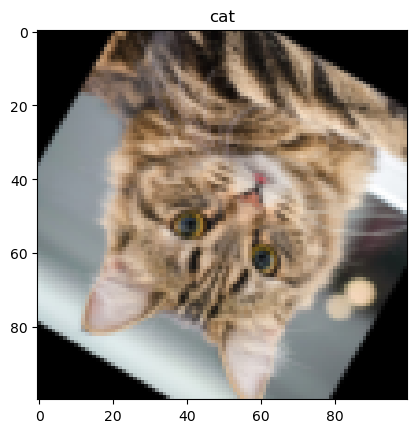

tensor([[0.0001]], grad_fn=<SigmoidBackward0>)


In [69]:
# 예측 
# 모델 학습 시 형태의 데이터로 전처리 진행
# processed_data = '전처리한 데이터'
# predict_value = model(processed_data)


img, target = testDS[2]


plt.imshow(img.permute(1,2,0))
plt.title(IDX_TO_CLASS[target])
plt.show()

predict_value = model(img.unsqueeze(0))
print(predict_value)